In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
columns = ['buying','maint','door','persons','lug_boot','safety','class values']
data=pd.read_csv('CarEvalutation.csv',names=columns)

In [3]:
data['class values'].value_counts()

unacc    1210
acc       384
good       69
vgood      65
Name: class values, dtype: int64

This dataset does not have any **missing values**, thus, we do the **label encoding.**

In [4]:
from sklearn.preprocessing import LabelEncoder
namesarray=data[data.columns[6]].copy()

le = LabelEncoder()
for i in data.columns:
    if data[i].dtype == 'object':
        data[i] = le.fit_transform(data[i]) #Fit label encoder and return encoded labels
data.head()

,buying,maint,door,persons,lug_boot,safety,class values
0,3,3,0,0,2,1,2
1,3,3,0,0,2,2,2
2,3,3,0,0,2,0,2
3,3,3,0,0,1,1,2
4,3,3,0,0,1,2,2


**This dataset has 4 classes.<br>
Thus, we create a map of colors & class names, and color & integers. The value of integers depends on how label encoders converts classes names into them.**

In [5]:
classes_names = set(namesarray)
np.random.seed(24)
ColormapforY = data[data.columns[6]].copy()
dictionforcolors={}
for elements in classes_names:
    index=namesarray.loc[namesarray == elements].index[0]
    yint=ColormapforY[index]
    color=tuple(np.random.rand(3))
    dictionforcolors[color]=elements
    ColormapforY.loc[ColormapforY == yint] = ColormapforY.loc[ColormapforY ==yint].apply(lambda x: color)
    

**Feature selection with recursive elimination:**

In [6]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
X = data[data.columns[0:6]]
Y = data[data.columns[6]]
LR = LogisticRegression(solver='newton-cg', C = 1e7,multi_class='ovr')

In [7]:
selector = RFECV(LR,step=1,cv=3,scoring='accuracy')
selector = selector.fit(X, Y)
print("\n")
print(np.c_[selector.ranking_,X.columns])
print(selector.grid_scores_)
print("Best number of features = {}".format(selector.n_features_))



[[5 'buying']
 [3 'maint']
 [4 'door']
 [1 'persons']
 [2 'lug_boot']
 [1 'safety']]
[0.70023188 0.71296742 0.67591925 0.65451524 0.61926245 0.61753637]
Best number of features = 2


In this case 'persons' and 'safety' seem to be most important parameters.<br>
Let's see how accuracy score changes with ranking.

In [8]:
from sklearn.metrics import accuracy_score
print('Features   :  Accuracy score')
for index in range(1,len(selector.ranking_)):
    X_red=X[X.columns[selector.ranking_<=index]]
    LR.fit(X_red,Y)
    prediction=LR.predict(X_red)
    accuracy=accuracy_score(prediction,Y)
    print(X.columns[selector.ranking_<=index].tolist(),': '+str(accuracy))

Features   :  Accuracy score
['persons', 'safety'] : 0.7274305555555556
['persons', 'lug_boot', 'safety'] : 0.6875
['maint', 'persons', 'lug_boot', 'safety'] : 0.6909722222222222
['maint', 'door', 'persons', 'lug_boot', 'safety'] : 0.6921296296296297
['buying', 'maint', 'door', 'persons', 'lug_boot', 'safety'] : 0.6961805555555556


**Let's make some plots.**

In [9]:
impcolumns=['maint', 'persons', 'lug_boot', 'safety']

In [10]:
import nbimporter
import Irisdataset as Plotter

Importing Jupyter notebook from Irisdataset.ipynb


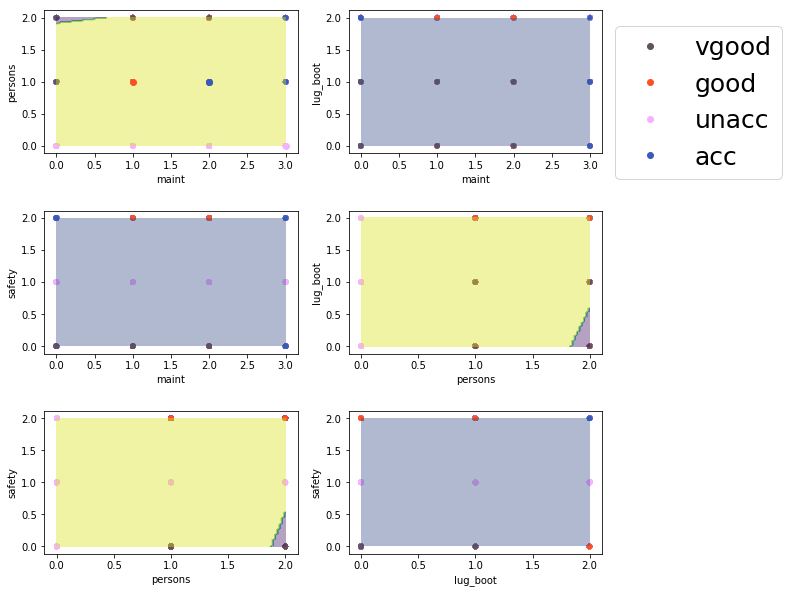

In [11]:
X_red=X[impcolumns]
axes=Plotter.plotfeatures(X_red, ColormapforY,decision_boundary=True, model=LR,solid=True,Y=Y)
Plotter.addlabels(X_red,ColormapforY,axes,dictionforcolors)

Since values from unaccepted class is quite high, the LR model maps all the values to this class and thus there are not any decision boundaries for this set.<br>
**Let's shake some points to see things clearly** (Reason for random noise is explained in Loanprediction_dataset notebook)

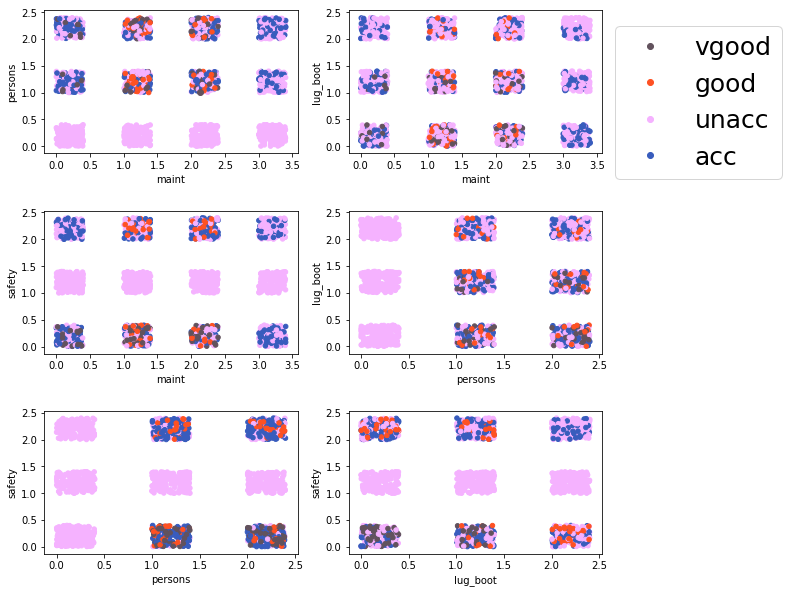

In [12]:
X_red += np.random.rand(X_red.shape[0],X_red.shape[1])*0.4
axes=Plotter.plotfeatures(X_red, ColormapforY)
Plotter.addlabels(X_red,ColormapforY,axes,dictionforcolors)

Interesting to observe the coordinates (x,y) for which are only blue (unaccepted).<br>
Let's check this.

In [13]:
namesarray[X['safety'] == 1].value_counts()

unacc    576
Name: class values, dtype: int64

In [14]:
namesarray[X['persons'] == 0].value_counts()

unacc    576
Name: class values, dtype: int64

These plots clarify why accuracy turns to be best for 'persons' and 'safety'. As the data is more clear for these features. In fact, from the plots with 'safety' and 'persons', it can be concluded definitely that if 'persons' variable is 0(**label encoded**) or if 'safety' variable is 1, car is always going to be rejected.<br>
**Let's remove these values as the Y values are definite for these features values. Also, the classes 'good' and 'vgood' are similar to 'accepted'. Let us replace these classes with "accepted" to make it binary classification problem**

In [15]:
X_new = X[(X['persons'] != 0) * (X['safety'] != 1)]
Y_new = Y[(X['persons'] != 0) * (X['safety'] != 1)]

In [16]:
Y_new.loc[(Y == 3.0)] = Y_new.loc[(Y_new == 3.0)].apply(lambda x: 0)
Y_new.loc[(Y == 1.0)] = Y_new.loc[(Y_new == 1.0)].apply(lambda x: 0)

In [17]:
print(Y.value_counts())

2    1210
0     384
1      69
3      65
Name: class values, dtype: int64


In [18]:
print(Y_new.value_counts())

0    518
2    250
Name: class values, dtype: int64


Thus, X_new --> Y_new is **binary classification** problem now.<br>
Let's do feature selection again.

In [19]:
selector = selector.fit(X_new, Y_new)
print("\n")
print(np.c_[selector.ranking_,X.columns])
print(selector.grid_scores_)
print("Best number of features = {}".format(selector.n_features_))



[[3 'buying']
 [2 'maint']
 [4 'door']
 [5 'persons']
 [1 'lug_boot']
 [1 'safety']]
[0.65888633 0.69530461 0.63696937 0.68631697 0.69023351 0.69023858]
Best number of features = 2


In [20]:
for index in range(1,len(selector.ranking_)):
    X_red=X_new[X_new.columns[selector.ranking_<=index]]
    LR.fit(X_red,Y_new)
    prediction=LR.predict(X_red)
    accuracy=accuracy_score(prediction,Y_new)
    print(X_new.columns[selector.ranking_<=index].tolist(),': '+str(accuracy))

['lug_boot', 'safety'] : 0.75
['maint', 'lug_boot', 'safety'] : 0.7421875
['buying', 'maint', 'lug_boot', 'safety'] : 0.7239583333333334
['buying', 'maint', 'door', 'lug_boot', 'safety'] : 0.75
['buying', 'maint', 'door', 'persons', 'lug_boot', 'safety'] : 0.7486979166666666


**Notice:** Accuracy on the training set is higher than the cross-validation accuracy. This is because the value of $C$ is high. This leads of overfitting of data.<br>
The accuracy has increased from original dataset. Choosing the 4 features which fit best with the data.

In [21]:
impcolumns2=['door', 'lug_boot', 'safety','persons']
X_red=X_new[impcolumns2]
LR.fit(X_red,Y_new)
prediction=LR.predict(X_red)
accuracy=accuracy_score(prediction,Y_new)
print(X_red.columns.tolist(),': '+str(accuracy))

['door', 'lug_boot', 'safety', 'persons'] : 0.7578125


**A new colormap:**

In [22]:
namesarray_new=namesarray[(X['persons'] != 0) * (X['safety'] != 1)]
namesarray_new.replace('good','acc', inplace=True)
namesarray_new.replace('vgood','acc', inplace=True)
classes_names2 = set(namesarray_new)
np.random.seed(24)

ColormapforY_new = Y_new.copy()
dictionforcolors={}
for elements in classes_names2:
    index=namesarray_new.loc[namesarray_new == elements].index[0]
    yint=ColormapforY_new[index]
    color=tuple(np.random.rand(3))
    dictionforcolors[color]=elements
    ColormapforY_new.loc[ColormapforY_new == yint] = ColormapforY_new.loc[ColormapforY_new ==yint].apply(lambda x: color)
    

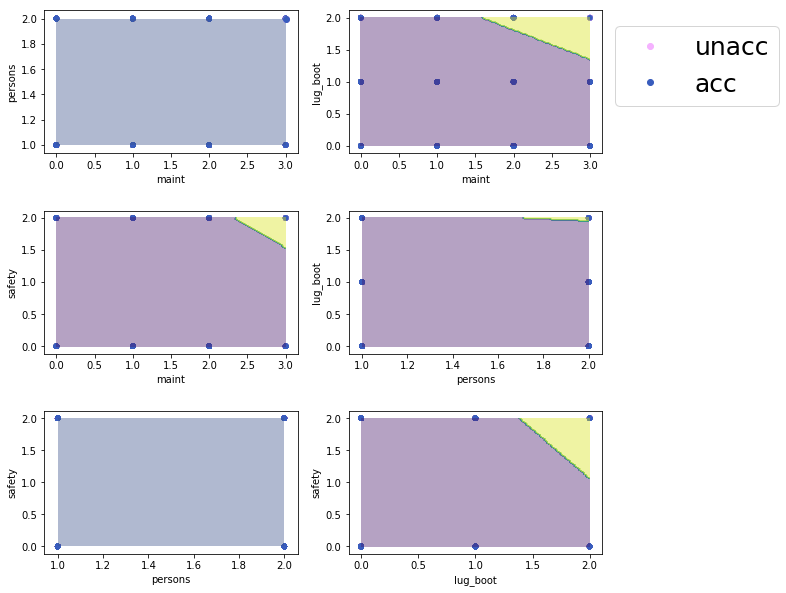

In [23]:
impcolumns2=['door', 'persons', 'lug_boot', 'safety']
X_red=X_new[impcolumns]
axes=Plotter.plotfeatures(X_red, ColormapforY_new,decision_boundary=True, model=LR, solid=True,Y=Y_new)
Plotter.addlabels(X_red,ColormapforY_new,axes,dictionforcolors)

These decision boudaries have gotten slightly better.<br>
Let's see the distribution.

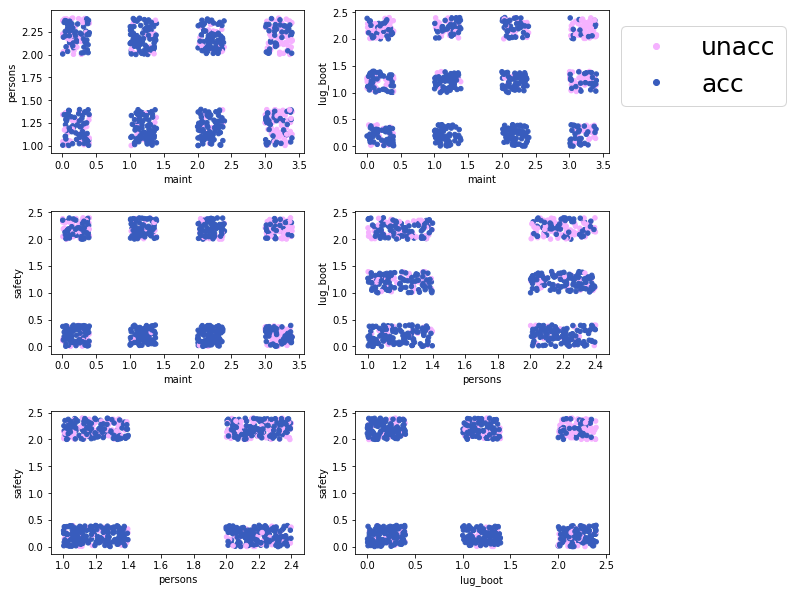

In [24]:
X_red += np.random.rand(X_red.shape[0],X_red.shape[1])*0.4
axes=Plotter.plotfeatures(X_red, ColormapforY_new)
Plotter.addlabels(X_red,ColormapforY_new,axes,dictionforcolors)

Let's write this data into a file.

In [25]:
Y_new.replace(2.0,1.0,inplace=True)
import csv
d = np.c_[X_new[impcolumns2],Y_new]

header = impcolumns +["Classes"]
with open('Carevaluation.csv', 'w', newline='') as myfile:
    wr = csv.writer(myfile)
    wr.writerow((header))
    wr.writerows(d)
myfile.close()